## Исследование мобильного приложения

У нас есть стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Так же у нас есть данные A/A/B-эксперимента, в котором дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше. Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.|

Мы имеем следующие данные о пользователях:
- название события 
- уникальный идентификатор пользователя
- время события
- номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

**Цель исследования:** 
- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента и выяснить, какой шрифт лучше.

**Ход исследования:** 
- Подготовить данные
- Изучить и проверить данные
- Изучить воронку событий
- Изучить результаты эксперимента

### Добавим необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.stats.proportion as smp

### Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм.

In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp.csv',sep='\t')
except:
    data = pd.read_csv('/Users/a0000/Documents/Analitic/All_projects/Project9_logs_AB/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Подготовим данные

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Заменим названия столбцов на удобные для нас

In [5]:
data = data.rename(columns = {
    'EventName':'event_name',
    'DeviceIDHash':'user_id',
    'EventTimestamp':'datetime',
    'ExpId':'group'
})

### Проверим пропуски и типы данных.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   datetime    244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
data.isna().sum()

event_name    0
user_id       0
datetime      0
group         0
dtype: int64

In [8]:
data.duplicated().sum()

413

In [9]:
data = data.drop_duplicates()

In [10]:
data.duplicated().sum()

0

**Промежуточный вывод:** Пропусков в данных не обнаружено, дупликаты удалены.

In [11]:
data.head()

,event_name,user_id,datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Добавим столбец даты и времени, а также отдельный столбец дат;

In [12]:
data['datetime'] = pd.to_datetime(data['datetime'], unit='s')

In [13]:
data['date'] = data['datetime'].dt.floor('D')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   datetime    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


## Изучим и проверим данные

## Сколько всего событий в логе?

In [15]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**Промежуточный вывод:** Мы имеем 5 событий:
- MainScreenAppear - Появится главный экран
- PaymentScreenSuccessful - Платежный экран успешно выполнен
- CartScreenAppear - Появится экран корзины
- OffersScreenAppear - Появится экран предложений
- Tutorial - Руководство

### Сколько всего пользователей в логе?

In [16]:
data['user_id'].nunique()

7551

**Промежуточный вывод:** В логе 7551 пользователей

### Сколько в среднем событий приходится на пользователя?

In [17]:
ds = data.groupby('user_id').agg({'event_name':'count'})
ds['event_name'].mean()

32.27559263673685

**Промежуточный вывод:** В среднем на пользователя приходится 32 события.

### Найдем максимальную и минимальную дату.

In [18]:
print(f"Минимальная дата: {data['date'].min()}")
print(f"Максимальная дата: {data['date'].max()}")

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


### Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Определим, с какого момента данные полные и отбросьте более старые. Данными за какой период времени мы  располагаем на самом деле?

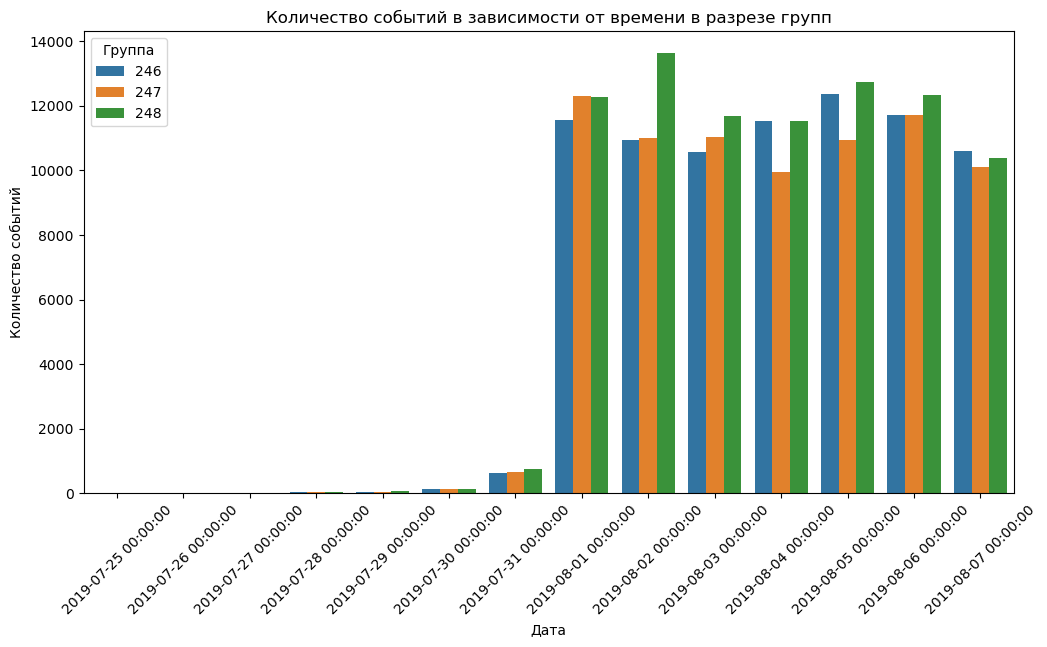

In [19]:
grouped_data = data.groupby(['date', 'group']).size().reset_index(name='count')

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='date', y='count', hue='group')

plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(title='Группа')
plt.xticks(rotation=45)
plt.show()

**Промежуточный вывод:** Мы распологаем данными с 2019-07-25 по 2019-08-07, но полные данные мы получаем с 2019-08-01 по 2019-08-07.

Отбросим более старые данные

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [20]:
filtered_data = data[data['date'] >= pd.Timestamp('2019-08-01')]

# Подсчет количества событий до и после фильтрации
events_before = data['event_name'].value_counts()
events_after = filtered_data['event_name'].value_counts()

# Подсчет количества уникальных пользователей до и после фильтрации
users_before = data['user_id'].nunique()
users_after = filtered_data['user_id'].nunique()

# Расчет абсолютных и относительных потерь по событиям
events_loss_absolute = events_before - events_after
events_loss_relative = events_loss_absolute / events_before

# Расчет абсолютных и относительных потерь по пользователям
users_loss_absolute = users_before - users_after
users_loss_relative = users_loss_absolute / users_before

# Вывод результатов
print("Потери по событиям:")
print("Абсолютные потери:")
print(events_loss_absolute)
print("Относительные потери:")
print(round(events_loss_relative,3))

print("\nПотери по пользователям:")
print("Абсолютные потери:")
print(users_loss_absolute)
print("Относительные потери:")
print(round(users_loss_relative,4))
data = data[data['date'] >= pd.Timestamp('2019-08-01')]

Потери по событиям:
Абсолютные потери:
event_name
MainScreenAppear           1773
OffersScreenAppear          475
CartScreenAppear            365
PaymentScreenSuccessful     200
Tutorial                     13
Name: count, dtype: int64
Относительные потери:
event_name
MainScreenAppear           0.015
OffersScreenAppear         0.010
CartScreenAppear           0.009
PaymentScreenSuccessful    0.006
Tutorial                   0.013
Name: count, dtype: float64

Потери по пользователям:
Абсолютные потери:
17
Относительные потери:
0.0023


**Промежуточный вывод:** Отбросив старые данные мы потеряли 2826 строк, Потери по пользователям:
Абсолютные потери: 17. Относительные потери: 0.0023

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [21]:
data.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

**Промежуточный вывод:** Пользователи из всех трех экспериментальных групп есть.

## Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

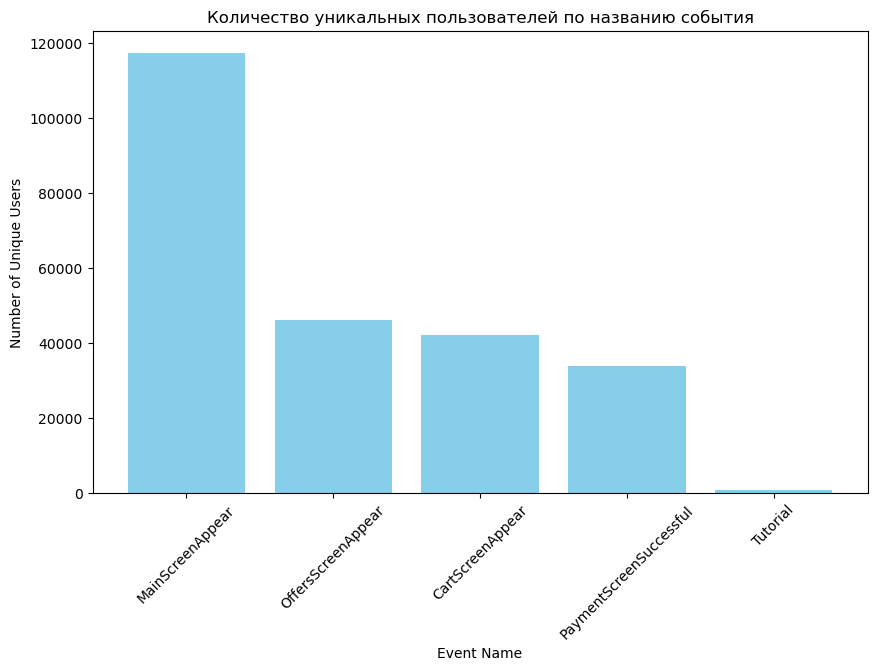

In [22]:
events_group = data.groupby('event_name')['user_id'].count().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(events_group.index, events_group.values, color='skyblue')
plt.xlabel('Event Name')
plt.ylabel('Number of Unique Users')
plt.title('Количество уникальных пользователей по названию события')
plt.xticks(rotation=45)
plt.show()

**Промежуточный вывод:** Чаще всего встречается событие MainScreenAppear, после него появляется OffersScreenAppear -> CartScreenAppear - > PaymentScreenSuccessful

Меньше всего пользуются событием Tutorial

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [23]:
events_users = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
events_users

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

In [24]:
total_users = data['user_id'].nunique()
events_users_share = round(events_users / total_users * 100,2)
events_users_share

event_name
MainScreenAppear           98.47
OffersScreenAppear         60.96
CartScreenAppear           49.56
PaymentScreenSuccessful    46.97
Tutorial                   11.15
Name: user_id, dtype: float64

**Промежуточный вывод:** Доли пользователей, которые хоть раз совершали события:
- MainScreenAppear - 98.47%
- OffersScreenAppear - 60.96%
- CartScreenAppear - 49.56%
- PaymentScreenSuccessful - 46.97%
- Tutorial - 11.15%

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

**Промежуточный вывод:** Tutorial -> MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

Tutorial: Пользователь просматривает обучающий материал (это событие может происходить в любой момент, но чаще всего в начале использования приложения).

Так как мы рассчитываем воронку продаж, то событие Tutorial можно не учитывать, так как оно не является частью основного пути пользователя к покупке.

Основная цепочка событий для воронки продаж будет выглядеть так: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [25]:
events_users = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

# Определение последовательности событий для воронки
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Фильтрация данных для событий воронки
funnel_data = events_users[events_users.index.isin(funnel_events)]

# Расчет доли пользователей, проходящих на следующий шаг воронки
funnel_conversion = {}
for i in range(len(funnel_events) - 1):
    current_event = funnel_events[i]
    next_event = funnel_events[i + 1]
    conversion_rate = funnel_data[next_event] / funnel_data[current_event]
    funnel_conversion[f'{current_event} -> {next_event}'] = conversion_rate

# Вывод результатов
print("Доля пользователей, проходящих на следующий шаг воронки:")
for step, rate in funnel_conversion.items():
    print(f"{step}: {rate:.2%}")

Доля пользователей, проходящих на следующий шаг воронки:
MainScreenAppear -> OffersScreenAppear: 61.91%
OffersScreenAppear -> CartScreenAppear: 81.30%
CartScreenAppear -> PaymentScreenSuccessful: 94.78%


### На каком шаге теряете больше всего пользователей?

**Промежуточный вывод:** Больше всего пользователей теряется при шаге MainScreenAppear -> OffersScreenAppear, почти 39% пользователей.

Какая доля пользователей доходит от первого события до оплаты?

In [26]:
first_event = 'MainScreenAppear'
payment_event = 'PaymentScreenSuccessful'

first_event_users = events_users[first_event]

payment_event_users = events_users[payment_event]

conversion_rate = payment_event_users / first_event_users * 100
conversion_rate

47.70184661005526

**Промежуточный вывод:** 47% пользователей доходит от первого события до оплаты.

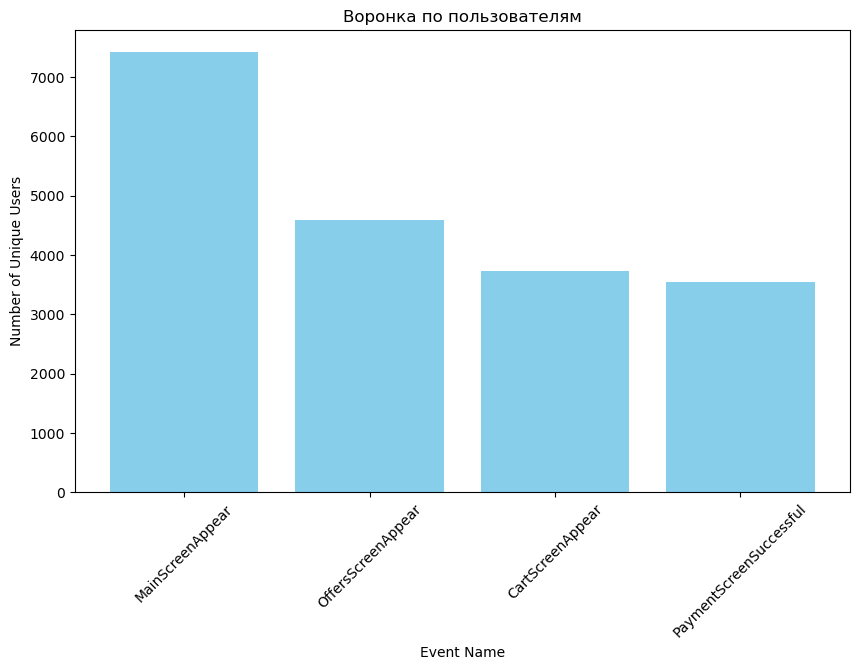

In [27]:
events_users = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
del events_users['Tutorial']
plt.figure(figsize=(10, 6))
plt.bar(events_users.index, events_users.values, color='skyblue')
plt.xlabel('Event Name')
plt.ylabel('Number of Unique Users')
plt.title('Воронка по пользователям')
plt.xticks(rotation=45)
plt.show()

## Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [28]:
group_users = data.groupby('group')['user_id'].nunique().sort_values(ascending=True)
group_users

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

**Промежуточный вывод:** 
- Группа 246 - 2484 пользователя
- Группа 247 - 2513 пользователя
- Группа 248 - 2537 пользователя

In [29]:
user_group_counts = data.groupby('user_id')['group'].nunique()

# Вывод результатов
if (user_group_counts > 1).any():
    print("Ошибка: Некоторые пользователи принадлежат нескольким группам.")
    print("Пользователи, принадлежащие нескольким группам:")
    print(user_group_counts[user_group_counts > 1])
else:
    print("Все пользователи принадлежат только одной группе.")

Все пользователи принадлежат только одной группе.


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Создадим таблицу с числом ползователей по группам и событиям 

In [30]:
kontrol_group = data.pivot_table(index = 'group', columns = 'event_name', values = 'user_id', aggfunc = 'nunique')
del kontrol_group['Tutorial']
kontrol_group['total_users'] = data.groupby('group')['user_id'].nunique().sort_values(ascending=True)
kontrol_group

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total_users
group,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


Создадим функцию для проверки гипотез
- Нулева гипотеза: нет оснований считать доли разными
- Альтернативная гипотеза: между долями есть значимая разница

In [31]:
group_246_247 = kontrol_group.loc[[246,247]]
del group_246_247['total_users']
group_246_247

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
group,,,,
246,1266,2450,1542,1200
247,1238,2476,1520,1158


In [32]:
group_246 = kontrol_group.loc[246]
group_246

event_name
CartScreenAppear           1266
MainScreenAppear           2450
OffersScreenAppear         1542
PaymentScreenSuccessful    1200
total_users                2484
Name: 246, dtype: int64

In [33]:
group_246 = kontrol_group.loc[246].drop('total_users')
group_247 = kontrol_group.loc[247].drop('total_users')
# Проведение z-теста для пропорций для каждого события
results = {}
for event in group_246.index:
    count_246 = group_246[event]
    count_247 = group_247[event]
    total_246 = kontrol_group.loc[246, 'total_users']
    total_247 = kontrol_group.loc[247, 'total_users']

    z_stat, p_value = smp.proportions_ztest([count_246, count_247], [total_246, total_247])
    results[event] = {'z_stat': z_stat, 'p_value': p_value}
    

# Вывод результатов
print("Результаты z-теста для пропорций для каждого события:")
for event, result in results.items():
    print(f"Событие: {event}")
    print(f"z-статистика: {result['z_stat']:.4f}")
    print(f"p-значение: {result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

Результаты z-теста для пропорций для каждого события:
Событие: CartScreenAppear
z-статистика: 1.2034
p-значение: 0.2288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
z-статистика: 0.3093
p-значение: 0.7571
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
z-статистика: 1.1550
p-значение: 0.2481
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
z-статистика: 1.5780
p-значение: 0.1146
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Промежуточный вывод:** Для 2 контрольных групп  А/А-эксперимента, нет оснований считать доли разными

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [34]:
# Функция для проверки статистической значимости различий между группами
def check_event_significance(event, kontrol_group, group1, group2):
    count_group1 = kontrol_group.loc[group1, event]
    count_group2 = kontrol_group.loc[group2, event]
    total_group1 = kontrol_group.loc[group1, 'total_users']
    total_group2 = kontrol_group.loc[group2, 'total_users']

    z_stat, p_value = smp.proportions_ztest([count_group1, count_group2], [total_group1, total_group2])

    return {
        'event': event,
        'z_stat': z_stat,
        'p_value': p_value,
        'count_group1': count_group1,
        'count_group2': count_group2,
        'total_group1': total_group1,
        'total_group2': total_group2
    }

# Проверка статистической значимости для всех событий
results = {}
for event in kontrol_group.columns:
    if event != 'total_users':
        results[event] = check_event_significance(event, kontrol_group, 246, 247)

# Вывод результатов
print("Результаты z-теста для пропорций для каждого события:")
for event, result in results.items():
    print(f"Событие: {event}")
    print(f"z-статистика: {result['z_stat']:.4f}")
    print(f"p-значение: {result['p_value']:.4f}")
    print(f"Число пользователей в группе 246: {result['count_group1']}")
    print(f"Число пользователей в группе 247: {result['count_group2']}")
    print(f"Общее число пользователей в группе 246: {result['total_group1']}")
    print(f"Общее число пользователей в группе 247: {result['total_group2']}")
    if result['p_value'] < 0.05:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

Результаты z-теста для пропорций для каждого события:
Событие: CartScreenAppear
z-статистика: 1.2034
p-значение: 0.2288
Число пользователей в группе 246: 1266
Число пользователей в группе 247: 1238
Общее число пользователей в группе 246: 2484
Общее число пользователей в группе 247: 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
z-статистика: 0.3093
p-значение: 0.7571
Число пользователей в группе 246: 2450
Число пользователей в группе 247: 2476
Общее число пользователей в группе 246: 2484
Общее число пользователей в группе 247: 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
z-статистика: 1.1550
p-значение: 0.2481
Число пользователей в группе 246: 1542
Число пользователей в группе 247: 1520
Общее число пользователей в группе 246: 2484
Общее число пользователей в группе 247: 2513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событ

**Промежуточный вывод:** Самое популярное событие MainScreenAppear, для групп 246 и 247 мы выяснили, что нет оснований считать доли разными

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [35]:
# Проверка статистической значимости для всех событий
results = {}
for event in kontrol_group.columns:
    if event != 'total_users':
        results[event] = check_event_significance(event, kontrol_group, 246, 248)

# Вывод результатов
print("Результаты z-теста для пропорций для каждого события:")
for event, result in results.items():
    print(f"Событие: {event}")
    print(f"z-статистика: {result['z_stat']:.4f}")
    print(f"p-значение: {result['p_value']:.4f}")
    print(f"Число пользователей в группе 246: {result['count_group1']}")
    print(f"Число пользователей в группе 248: {result['count_group2']}")
    print(f"Общее число пользователей в группе 246: {result['total_group1']}")
    print(f"Общее число пользователей в группе 248: {result['total_group2']}")
    if result['p_value'] < 0.05:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

Результаты z-теста для пропорций для каждого события:
Событие: CartScreenAppear
z-статистика: 1.7599
p-значение: 0.0784
Число пользователей в группе 246: 1266
Число пользователей в группе 248: 1230
Общее число пользователей в группе 246: 2484
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
z-статистика: 1.0473
p-значение: 0.2950
Число пользователей в группе 246: 2450
Число пользователей в группе 248: 2493
Общее число пользователей в группе 246: 2484
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
z-статистика: 1.2581
p-значение: 0.2084
Число пользователей в группе 246: 1542
Число пользователей в группе 248: 1531
Общее число пользователей в группе 246: 2484
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событ

**Промежуточный вывод:** Для групп 246 и 248 мы выяснили, что нет оснований считать доли разными

In [36]:
results = {}
for event in kontrol_group.columns:
    if event != 'total_users':
        results[event] = check_event_significance(event, kontrol_group, 247, 248)

# Вывод результатов
print("Результаты z-теста для пропорций для каждого события:")
for event, result in results.items():
    print(f"Событие: {event}")
    print(f"z-статистика: {result['z_stat']:.4f}")
    print(f"p-значение: {result['p_value']:.4f}")
    print(f"Число пользователей в группе 247: {result['count_group1']}")
    print(f"Число пользователей в группе 248: {result['count_group2']}")
    print(f"Общее число пользователей в группе 247: {result['total_group1']}")
    print(f"Общее число пользователей в группе 248: {result['total_group2']}")
    if result['p_value'] < 0.05:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

Результаты z-теста для пропорций для каждого события:
Событие: CartScreenAppear
z-статистика: 0.5554
p-значение: 0.5786
Число пользователей в группе 247: 1238
Число пользователей в группе 248: 1230
Общее число пользователей в группе 247: 2513
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
z-статистика: 0.7410
p-значение: 0.4587
Число пользователей в группе 247: 2476
Число пользователей в группе 248: 2493
Общее число пользователей в группе 247: 2513
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
z-статистика: 0.1007
p-значение: 0.9198
Число пользователей в группе 247: 1520
Число пользователей в группе 248: 1531
Общее число пользователей в группе 247: 2513
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событ

**Промежуточный вывод:** Для групп 247 и 248 мы выяснили, что нет оснований считать доли разными

### Проверим объединенную 246+247 и 248 группу

In [37]:
group_246 = kontrol_group.loc[246].drop('total_users')
group_247 = kontrol_group.loc[247].drop('total_users')

# Создание общей группы 246 и 247
group_combined = group_246.add(group_247, fill_value=0)
group_combined['total_users'] = kontrol_group.loc[246, 'total_users'] + kontrol_group.loc[247, 'total_users']

# Фильтрация данных для группы 248
group_248 = kontrol_group.loc[248].drop('total_users')

# Функция для проверки статистической значимости различий между группами
def check_event_significance(event, group1, group2, total_group1, total_group2):
    count_group1 = group1[event]
    count_group2 = group2[event]

    z_stat, p_value = smp.proportions_ztest([count_group1, count_group2], [total_group1, total_group2])

    return {
        'event': event,
        'z_stat': z_stat,
        'p_value': p_value,
        'count_group1': count_group1,
        'count_group2': count_group2,
        'total_group1': total_group1,
        'total_group2': total_group2
    }

# Проверка статистической значимости для всех событий
results = {}
for event in group_combined.index:
    if event != 'total_users':
        results[event] = check_event_significance(event, group_combined, group_248, group_combined['total_users'], kontrol_group.loc[248, 'total_users'])

# Вывод результатов
print("Результаты z-теста для пропорций для каждого события:")
for event, result in results.items():
    print(f"Событие: {event}")
    print(f"z-статистика: {result['z_stat']:.4f}")
    print(f"p-значение: {result['p_value']:.4f}")
    print(f"Число пользователей в объединенной группе 246+247: {result['count_group1']}")
    print(f"Число пользователей в группе 248: {result['count_group2']}")
    print(f"Общее число пользователей в объединенной группе 246+247: {result['total_group1']}")
    print(f"Общее число пользователей в группе 248: {result['total_group2']}")
    if result['p_value'] < 0.05:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

Результаты z-теста для пропорций для каждого события:
Событие: CartScreenAppear
z-статистика: 1.3354
p-значение: 0.1818
Число пользователей в объединенной группе 246+247: 2504
Число пользователей в группе 248: 1230
Общее число пользователей в объединенной группе 246+247: 4997
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: MainScreenAppear
z-статистика: 1.0489
p-значение: 0.2942
Число пользователей в объединенной группе 246+247: 4926
Число пользователей в группе 248: 2493
Общее число пользователей в объединенной группе 246+247: 4997
Общее число пользователей в группе 248: 2537
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
z-статистика: 0.7819
p-значение: 0.4343
Число пользователей в объединенной группе 246+247: 3062
Число пользователей в группе 248: 1531
Общее число пользователей в объединенной группе 246+247: 4997
Общее число пользователей в

**Промежуточный вывод:** Для групп 246+247 и 248 мы выяснили, что нет оснований считать доли разными

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Мы выбрали уровень статистической значимости в 0.05 или 5% случае в которых можно ошибочно отклонить нулевую гипотезу при условии, что она верна и везде получили вывод, что нет оснований считать доли разными

Между группами 246 и 248 при уровне значимости в 0.1 или 10% случаев когда можно ошибочно
Появляется значимая разница между долями при проведение теста для CartScreenAppear
- z-статистика: 1.7599
- p-значение: 0.0784
- Число пользователей в группе 246: 1266
- Число пользователей в группе 248: 1230
- Общее число пользователей в группе 246: 2484
- Общее число пользователей в группе 248: 2537

В остальных случаях при при уровне значимости в 0.1 или 10% случаев когда можно ошибочно нет отличий по сравнению с тестом для 0.05 или 5% случаев когда можно ошибочно

Лучше применить уровень значимости 0.05, чтобы получить более точные результаты

## Общий вывод:

Мы имеем 5 событий:
- MainScreenAppear - Появится главный экран
- PaymentScreenSuccessful - Платежный экран успешно выполнен
- CartScreenAppear - Появится экран корзины
- OffersScreenAppear - Появится экран предложений
- Tutorial - Руководство

Всего пользователей в логе 7551, в среднем на пользователя приходится 32 события. Нам были даны данные с  2019-07-25 по 2019-08-07,  но полные данные мы получаем с 2019-08-01 по 2019-08-07, поэтому мы отбросили более старые данные. Отбросив старые данные мы потеряли 2826 строк. 

Чаще всего встречается событие MainScreenAppear, после него появляется OffersScreenAppear -> CartScreenAppear - > PaymentScreenSuccessful. Меньше всего пользуются событием Tutorial

Доли пользователей, которые хоть раз совершали события:
- MainScreenAppear - 98.47%
- OffersScreenAppear - 60.96%
- CartScreenAppear - 49.56%
- PaymentScreenSuccessful - 46.97%
- Tutorial - 11.15%

Tutorial: Пользователь просматривает обучающий материал (это событие может происходить в любой момент, но чаще всего в начале использования приложения).

Так как мы рассчитываем воронку продаж, то событие Tutorial можно не учитывать, так как оно не является частью основного пути пользователя к покупке.

Основная цепочка событий для воронки продаж будет выглядеть так: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

Доля пользователей, проходящих на следующий шаг воронки:
- MainScreenAppear -> OffersScreenAppear: 61.91%
- OffersScreenAppear -> CartScreenAppear: 81.30%
- CartScreenAppear -> PaymentScreenSuccessful: 94.78%

Больше всего пользователей теряется при шаге MainScreenAppear -> OffersScreenAppear, почти 39% пользователей и  47% пользователей доходит от первого события до оплаты.

- Группа 246 содержит - 2484 пользователя
- Группа 247 содержит - 2513 пользователя
- Группа 248 содержит - 2537 пользователя


Для 2 контрольных групп А/А-эксперимента, нет оснований считать доли разными. Самое популярное событие MainScreenAppear, для групп 246 и 247 мы выяснили, что нет оснований считать доли разными. Для групп 246 и 248 мы выяснили, что нет оснований считать доли разными. Для групп 247 и 248 мы выяснили, что нет оснований считать доли разными   Для групп 246+247 и 248 мы выяснили, что нет оснований считать доли разными. Мы выбрали уровень статистической значимости в 0.05 или 5% случае в которых можно ошибочно отклонить нулевую гипотезу при условии, что она верна и везде получили вывод, что нет оснований считать доли разными
Между группами 246 и 248 при уровне значимости в 0.1 или 10% случаев когда можно ошибочно Появляется значимая разница между долями при проведение теста для CartScreenAppear
* z-статистика: 1.7599
* p-значение: 0.0784
* Число пользователей в группе 246: 1266
* Число пользователей в группе 248: 1230
* Общее число пользователей в группе 246: 2484
* Общее число пользователей в группе 248: 2537
В остальных случаях при при уровне значимости в 0.1 или 10% случаев когда можно ошибочно нет отличий по сравнению с тестом для 0.05 или 5% случаев когда можно ошибочно
Лучше применить уровень значимости 0.05, чтобы получить более точные результаты